In [249]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/home/isaac/gimmeSAD"
#SIMOUT_DIR = os.path.join(GIMME_DIR, "1d_sims/")
SIMOUT_DIR = "/tmp/sims/"
OBSERVED_FILE = os.path.join(GIMME_DIR, "empirical_data/spider.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
## Gather all the simulations from all the running hosts, assumes you're running on cattywampus
## Assumes you have sshpass installed
hosts = {"yowie":"isaac", "yeti":"isaac", "trashquatch":"labuser", "enterprise":"iovercast", "goatzilla":"isaac"}
passwd = {"yowie":"aardvark1", "yeti":"zastards", "trashquatch":"hickerlab", "enterprise":"watwatwat", "goatzilla":"hickerlab"}
simdir = {"yowie":"/Users/isaac/work/",
          "yeti":"/Volumes/WorkDrive/",
          "trashquatch":"/Users/labuser/Documents/isaac/",
          "enterprise":"/home/iovercast/",
          "goatzilla":"/home/isaac/"}

for host in hosts.keys():
    cmd = "sshpass -p \"{}\" scp -r {}@{}:{}gimmeSAD/1d_sims/* /tmp/sims/".format(passwd[host], hosts[host], host, simdir[host])
    print(cmd)
    os.system(cmd)


sshpass -p "aardvark1" scp -r isaac@yowie:/Users/isaac/work/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "watwatwat" scp -r iovercast@enterprise:/home/iovercast/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "hickerlab" scp -r labuser@trashquatch:/Users/labuser/Documents/isaac/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "hickerlab" scp -r isaac@goatzilla:/home/isaac/gimmeSAD/1d_sims/* /tmp/sims/


## Gather all the simulations into one huge simout file

In [290]:
REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
outfile = open(REF_TABLE, "w")

ONEPER = True
REGULARIZE = False
DROPEQUILIBSIMS = True

files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
numsims = 0
outfile.write(open(files[0]).readlines()[0])
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## DO or don't regularlize the histograms
            if REGULARIZE:
                hist = np.array([int(x) for x in line.split()[7:]])
                if np.sum(hist):
                    tot = np.sum(hist)
                    hist = hist/float(tot)
                tmp = line.split()[:7] + map(str,hist)
                line = " ".join(tmp) + "\n"
                new_lines.append(line)

            ## Do or don't drop all the extra sims at equilibrium
            if line.split()[3] == "1" and DROPEQUILIBSIMS:
                pass
            else:
                new_lines.append(line)
        except:
            pass
    lines = new_lines
    ## Only choose one step per simulation?
    if lines and ONEPER:
        lines = [random.choice(lines)]
    ## Don't write blanks
    if lines:
        numsims += len(lines)
        outfile.write("".join(lines))
        outfile.write("\n")
outfile.close()

print("Processed {} simulations.".format(numsims))

Processed 14640 simulations.


In [291]:
new_lines[0]
print(numsims)

14640


## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

## Load the data into R

In [315]:
%%R -i OBSERVED_FILE -i REF_TABLE
library(abc)

OBS<- read.table(OBSERVED_FILE, header=TRUE)

## fill adds NA for any incomplete row
PRIOR <- read.table(REF_TABLE, header=TRUE, fill=TRUE)
print(PRIOR[1,])
print(OBS)

     K         c   step   X.equil colrate   extrate  shannon bin_0 bin_1 bin_2
1 4606 0.0277614 400000 0.9140252 0.02745 0.0056325 3.561625    79    86     6
  bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     4     5     2     3     0     0     2
   shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1 3.737537     8    25     7     4     1     3     2     4     1     2


In [262]:
%%R
## Do or don't regularize the observed pi bins
if(TRUE){
    shan = OBS[1]
    tot = sum(OBS[2:11])
    OBS = data.frame(c(shan, OBS[2:11]/tot))
    print(OBS)
}

   shannon     bin_0     bin_1    bin_2      bin_3      bin_4      bin_5
1 3.737537 0.1403509 0.4385965 0.122807 0.07017544 0.01754386 0.05263158
       bin_6      bin_7      bin_8      bin_9
1 0.03508772 0.07017544 0.01754386 0.03508772


## Estimate % equilibrium using shannon index and 1d pi vector


### Rejection

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.4023809
0.01  0.3836691
0.05  0.4497157


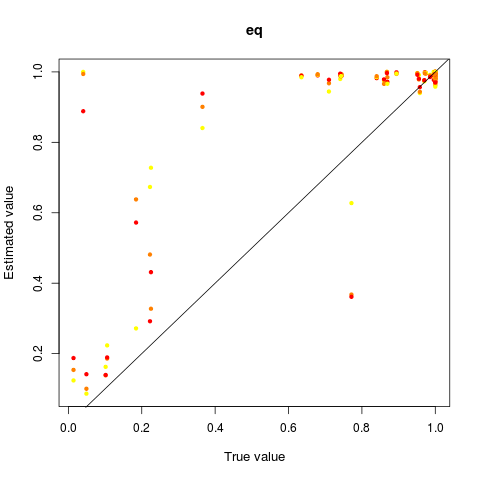

In [263]:
%%R
cv.res.rej <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(0.005,.05,.01), method="rejection")
print(summary(cv.res.rej))
plot(cv.res.rej)

### Loclinear regression

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.1871502
0.01  0.1632591
0.05  0.1547410


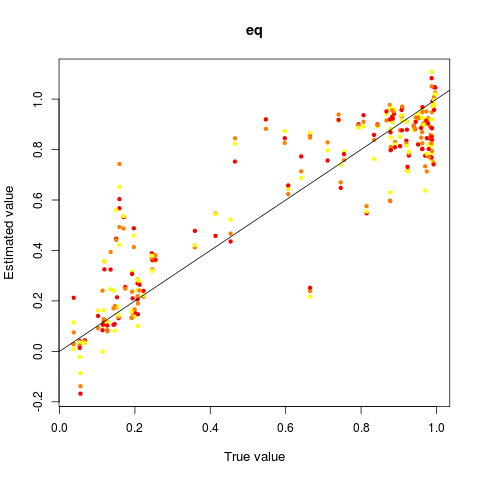

In [293]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Results with pi vectors regularized to sum to 1

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.2033284
0.01  0.1865948
0.05  0.2067215


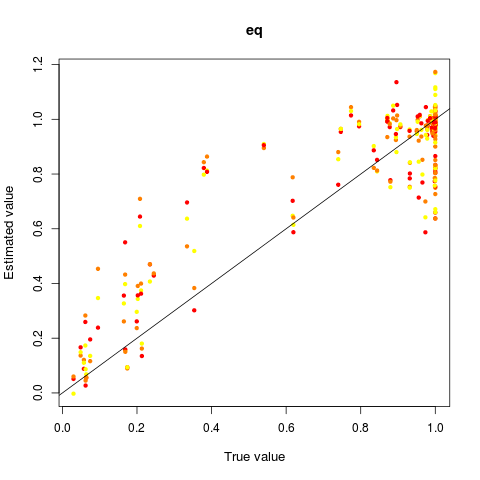

In [289]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Do the ABC

12345678910
12345678910
Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7:17], tol = 0.01, method = "neuralnet")
Data:
 abc.out$adj.values (147 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.9124
Weighted 2.5 % Perc.:  0.9771
Weighted Median:       0.9936
Weighted Mean:         0.9897
Weighted Mode:         0.9948
Weighted 97.5 % Perc.: 0.9985
Max.:                  1.0103
                              eq
Min.:                  0.9123712
Weighted 2.5 % Perc.:  0.9771487
Weighted Median:       0.9935662
Weighted Mean:         0.9896821
Weighted Mode:         0.9948418
Weighted 97.5 % Perc.: 0.9985303
Max.:                  1.0103312


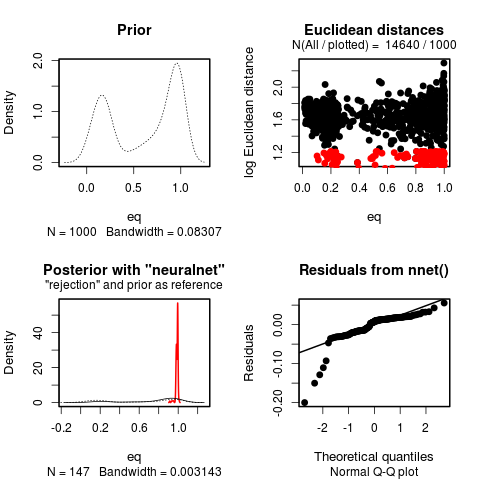

In [312]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.01, method="neuralnet")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

In [316]:
%%R
res.abc$ss

        shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
  [1,] 3.257509    76    40     6     4     2     3     2     3     0     2
  [2,] 2.955322    42    35     8     4     0     1     4     2     0     2
  [3,] 3.447879    40    29    10     2     0     2     2     4     1     2
  [4,] 3.062392    51    44     5     6     0     2     2     2     0     1
  [5,] 3.251002    60    43     4     6     0     0     1     4     1     1
  [6,] 3.409516    72    55     9     3     1     2     3     2     1     2
  [7,] 2.131541    37    33     4     4     2     2     3     3     1     1
  [8,] 3.445052    36    36    14     5     4     3     1     4     0     1
  [9,] 2.890917    42    38     3     2     1     3     1     2     0     1
 [10,] 2.945705    19    19    12     4     1     1     0     3     0     1
 [11,] 3.072906    59    58    12     5     2     3     1     2     1     2
 [12,] 3.454007    50    37     9     2     2     3     1     3     1     1
 [13,] 2.712

## Estimate colonization rate using shannon index and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.2037618
0.01  0.1878965
0.05  0.1785994


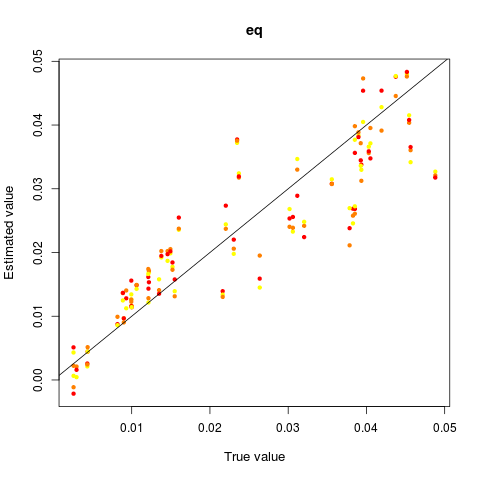

In [317]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7:17], nval=50, tols=c(.005, .01, 0.05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(colrate = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 7:17], tol = 0.01, method = "loclinear")
Data:
 abc.out$adj.values (147 posterior samples)
Weights:
 abc.out$weights

                       colrate
Min.:                  -0.0085
Weighted 2.5 % Perc.:  -0.0035
Weighted Median:        0.0007
Weighted Mean:          0.0010
Weighted Mode:          0.0013
Weighted 97.5 % Perc.:  0.0111
Max.:                   0.0111
                            colrate
Min.:                  -0.008467784
Weighted 2.5 % Perc.:  -0.003499701
Weighted Median:        0.000732211
Weighted Mean:          0.001048440
Weighted Mode:          0.001285276
Weighted 97.5 % Perc.:  0.011087155
Max.:                   0.011087155


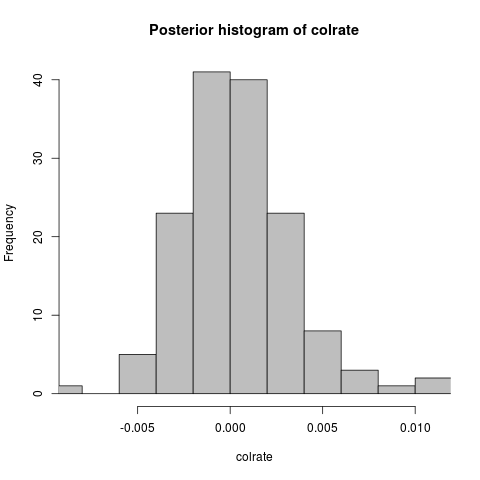

In [276]:
%%R
res.abc = abc(target=OBS, param=data.frame(colrate=PRIOR[,"colrate"]), sumstat=PRIOR[,7:17], tol=0.01, method="loclinear")
print(summary(res.abc))
hist(res.abc)
#plot(res.abc, param=PRIOR[,"colrate"])

## Estimate shannon using only 1d pi vector

Prediction error based on a cross-validation sample of 100

           shan
0.005 0.2953599
0.01  0.2629440
0.05  0.2589105


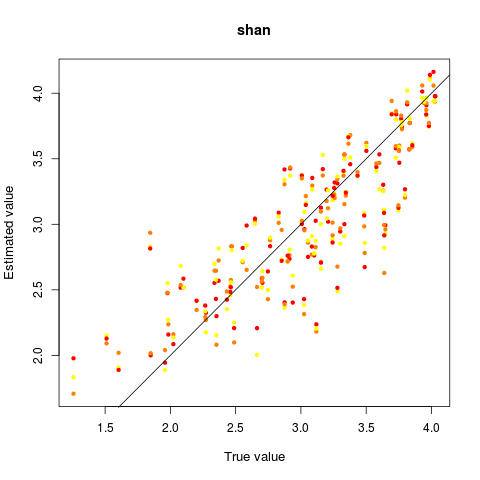

In [318]:
%%R
cv.res.reg <- cv4abc(data.frame(shan=PRIOR[,"shannon"]), PRIOR[,8:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[2:11], param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 8:17], tol = 0.05, method = "loclinear")
Data:
 abc.out$adj.values (732 posterior samples)
Weights:
 abc.out$weights

                         shan
Min.:                  1.5443
Weighted 2.5 % Perc.:  2.6642
Weighted Median:       3.3170
Weighted Mean:         3.2989
Weighted Mode:         3.3305
Weighted 97.5 % Perc.: 3.9278
Max.:                  4.2186
                           shan
Min.:                  1.544262
Weighted 2.5 % Perc.:  2.664221
Weighted Median:       3.317048
Weighted Mean:         3.298896
Weighted Mode:         3.330506
Weighted 97.5 % Perc.: 3.927816
Max.:                  4.218637


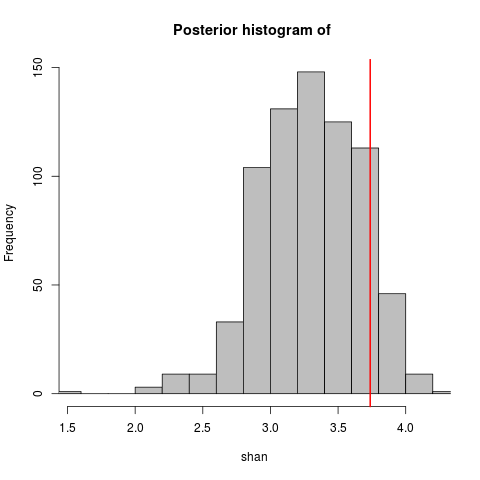

In [319]:
%%R
res.abc = abc(target=OBS[2:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17], tol=0.05, method="loclinear")
print(summary(res.abc))
hist(res.abc, true=3.737537, cap="", breaks=10)
#plot(res.abc, param=PRIOR[,"shannon"])

## Estimate %equil using only 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.7258480
0.01  0.7412858
0.05  0.7583425


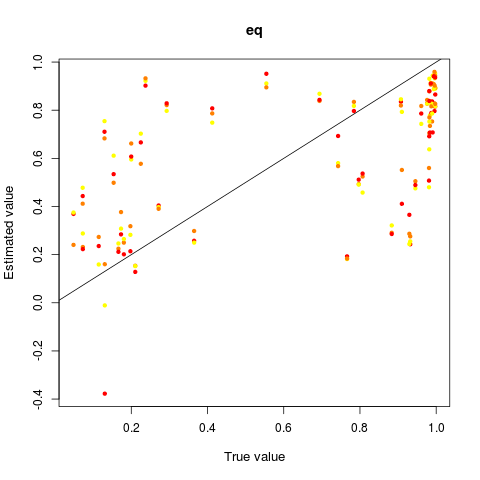

In [321]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,9:17], nval=50, tols=c(.005, .01, .05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[3:11], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 9:17], tol = 0.01, method = "loclinear")
Data:
 abc.out$adj.values (147 posterior samples)
Weights:
 abc.out$weights

                            eq
Min.:                  -0.0488
Weighted 2.5 % Perc.:  -0.0182
Weighted Median:        0.4072
Weighted Mean:          0.4340
Weighted Mode:          0.1894
Weighted 97.5 % Perc.:  0.9340
Max.:                   1.3661
                                eq
Min.:                  -0.04882552
Weighted 2.5 % Perc.:  -0.01820532
Weighted Median:        0.40722692
Weighted Mean:          0.43404115
Weighted Mode:          0.18939160
Weighted 97.5 % Perc.:  0.93402375
Max.:                   1.36609204


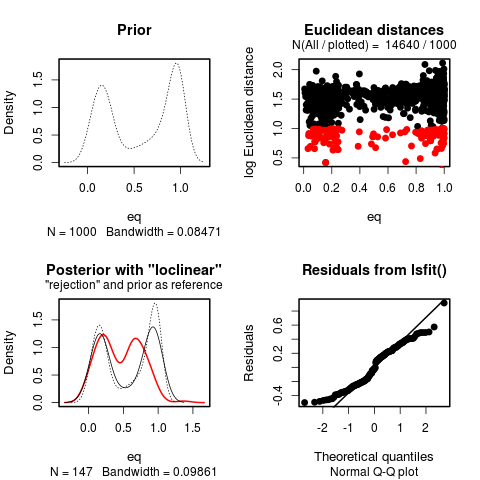

In [326]:
%%R
res.abc = abc(target=OBS[3:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,9:17], tol=0.01, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

## Estimate %equil using only shannon

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.3428286
0.01  0.3486149
0.05  0.3220264


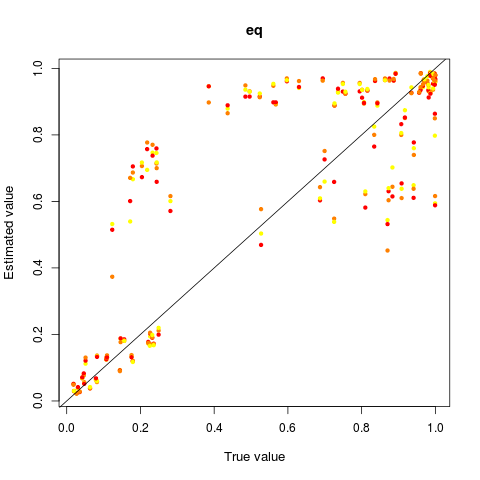

In [329]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7], nval=100, tols=c(.005, .01, .05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[, 1], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7], tol = 0.005, method = "loclinear")
Data:
 abc.out$adj.values (475 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.2624
Weighted 2.5 % Perc.:  0.3349
Weighted Median:       0.9949
Weighted Mean:         0.8385
Weighted Mode:         0.9961
Weighted 97.5 % Perc.: 1.0014
Max.:                  1.0014
                              eq
Min.:                  0.2623735
Weighted 2.5 % Perc.:  0.3348801
Weighted Median:       0.9949215
Weighted Mean:         0.8385153
Weighted Mode:         0.9961328
Weighted 97.5 % Perc.: 1.0013968
Max.:                  1.0013999


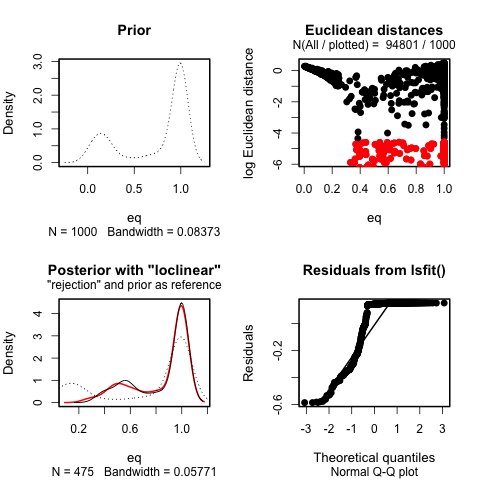

In [96]:
%%R
res.abc = abc(target=OBS[,1], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7], tol=0.005, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"X.equil"])

## Estimate island size using shannon and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.001 0.6453266
0.005 0.3867152
0.01  0.3609488
0.05  0.3812574
0.1   0.3750593


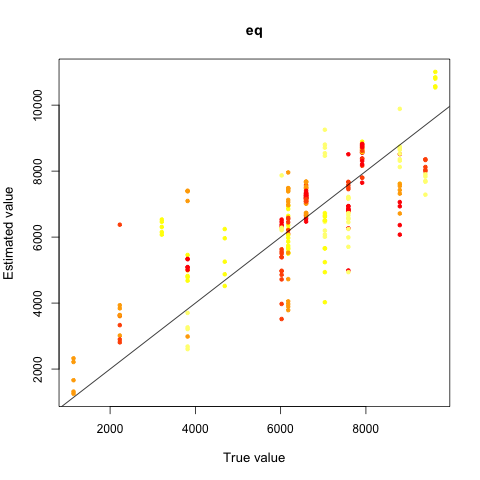

In [74]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"K"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "K"]), sumstat = PRIOR[, 
    7:17], tol = 0.05, method = "loclinear")
Data:
 abc.out$adj.values (4741 posterior samples)
Weights:
 abc.out$weights

                              eq
Min.:                   4237.161
Weighted 2.5 % Perc.:   5431.662
Weighted Median:        7963.660
Weighted Mean:          7908.706
Weighted Mode:          7764.804
Weighted 97.5 % Perc.:  9640.701
Max.:                  11308.365
                              eq
Min.:                   4237.161
Weighted 2.5 % Perc.:   5431.662
Weighted Median:        7963.660
Weighted Mean:          7908.706
Weighted Mode:          7764.804
Weighted 97.5 % Perc.:  9640.701
Max.:                  11308.365


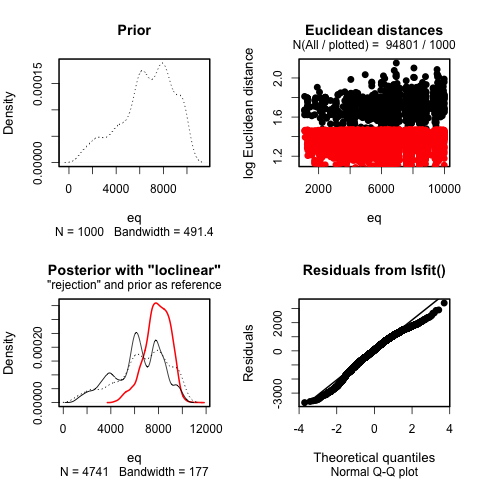

In [95]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"K"]), sumstat=PRIOR[,7:17], tol=0.05, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"K"])

# Co-estimate island size and %equil 

## Estimate island size/%equil using shannon and 1d pi vector

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = OBS, param = data.frame(k = PRIOR[, "K"], eq = PRIOR[, 
    "X.equil"]), sumstat = PRIOR[, 7:17], tol = 0.05, method = "loclinear")
Data:
 abc.out$adj.values (3679 posterior samples)
Weights:
 abc.out$weights

                                k         eq
Min.:                   3876.3373     0.1729
Weighted 2.5 % Perc.:   5462.2696     0.6628
Weighted Median:        8074.7916     0.8094
Weighted Mean:          7976.6834     0.8072
Weighted Mode:          7728.4728     0.8113
Weighted 97.5 % Perc.:  9545.4466     0.9480
Max.:                  10380.3491     1.1160
                                  k           eq
Min.:                  3.876337e+03 1.729484e-01
Weighted 2.5 % Perc.:  5.462270e+03 6.628112e-01
Weighted Median:       8.074792e+03 8.094355e-01
Weighted Mean:         7.976683e+03 8.071694e-01
Weighted Mode:         7.728473e+03 8.112688e-01
Weighted 97.5 % Perc.: 9.545447e+03 9.479953e-01
Max.:                  1.038035e+04 1.116049e+00


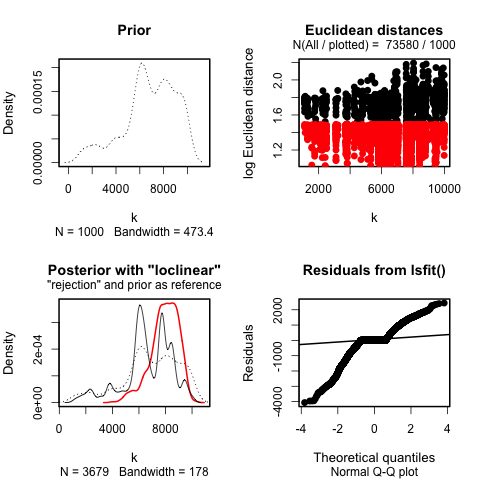

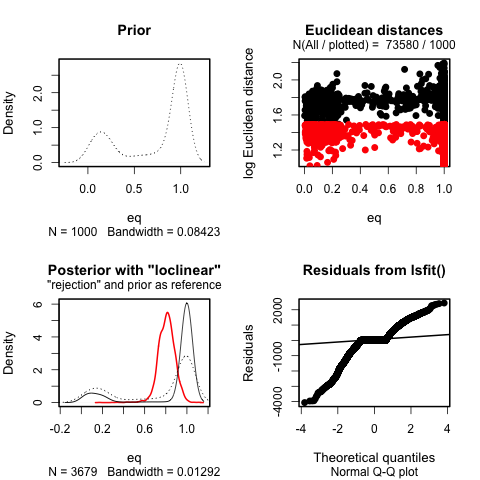

In [57]:
%%R
res.abc = abc(target=OBS, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.05, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]))